In [56]:
import json
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
import numpy as np 

In [57]:
def load_license_data(json_folder):
    license_data = []
    for filename in os.listdir(json_folder):
        if filename.endswith(".json"):
            license_name = filename[:-5]
            filepath = os.path.join(json_folder, filename)
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
                license_data.append({
                    "license_name": license_name,
                    "family": data["family"],
                    "labels": data["labels"],
                    "text": data["text"],
                })
    return license_data

json_folder = "../../data/processed/preprocessed_licenses_json_2"
license_data = load_license_data(json_folder)

# --- Create DataFrame ---
df = pd.DataFrame(license_data)

# --- Handle Missing Labels ---
df.dropna(subset=["labels"], inplace=True)
df = df[df["labels"].apply(lambda x: len(x) > 0)]

# --- Multi-Label Encoding ---
mlb = MultiLabelBinarizer()
multi_hot_labels = mlb.fit_transform(df["labels"])
df["multi_hot_labels"] = list(multi_hot_labels)
num_labels = len(mlb.classes_)
print(f"Number of unique labels: {num_labels}")
print(f"Classes: {mlb.classes_}")
labels = torch.tensor(multi_hot_labels, dtype=torch.float)

Number of unique labels: 29
Classes: ['Anti-DRM (obligation/WARNING)' 'Anti-Tivoization (obligation/WARNING)'
 'Copyleft (network protective) (obligation/ALARM)'
 'Copyleft (strong) (obligation/WARNING)'
 'Copyleft (weak) (obligation/WARNING)'
 'Declare modification in source code (obligation/WARNING)'
 'Deprecated License (other/INFORMATION)'
 'Display acknowledgement message (obligation/WARNING)'
 'Display additional information (obligation/WARNING)'
 'Display copyright notice (obligation/INFORMATION)'
 'Display license in binary (obligation/INFORMATION)'
 'Display license in the source (obligation/INFORMATION)'
 'Doing Business with US (other/ALARM)'
 'Endorsement prohibited (prohibition/INFORMATION)'
 'Jurisdiction specific (other/WARNING)'
 'Keep copy of source code available (obligation/WARNING)'
 'License upgrade allowed (right/INFORMATION)'
 'Limitation (limitation/WARNING)'
 'No further restrictions permitted (prohibition/INFORMATION)'
 'Patent grant (other/INFORMATION)' 'Perm

In [58]:
model_directory = "../../model/LegalBert"

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [61]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80/20 split

# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50/50 split (10/10)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 283
Validation set size: 35
Test set size: 36


In [62]:
# Tokenize validation data
val_encoded_inputs = tokenizer(
    val_df["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=1024
)

# Create validation labels
val_labels = torch.tensor(val_df["multi_hot_labels"].tolist(), dtype=torch.float)

# Create validation dataset and dataloader
val_dataset = TensorDataset(
    val_encoded_inputs["input_ids"],
    val_encoded_inputs["attention_mask"],
    val_labels
)

val_dataloader = DataLoader(val_dataset, batch_size=8)  # Adjust batch size

In [63]:
def optimize_thresholds(model, dataloader, device, metric="f1_micro"):
    """Optimizes the prediction thresholds for each label based on a validation set.

    Args:
        model: The trained model.
        dataloader: The validation set dataloader.
        device: The device (CPU or GPU).
        metric: The metric to optimize ("f1_micro", "f1_macro", "f1_samples", "hamming", "exact_match").

    Returns:
        A tuple containing:
        - best_thresholds: A list of the best thresholds found for each label.
        - best_score: The best score achieved with the best thresholds.
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)  # Apply sigmoid to get probabilities

            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    num_labels = all_labels.shape[1]
    best_thresholds = [0.5] * num_labels  # Initialize with default threshold
    best_score = 0

    # Iterate over each label and find the best threshold
    for i in range(num_labels):
        best_threshold = 0.5
        if metric.startswith("f1_"):
            best_score = -1  # For F1, higher is better
        elif metric == "hamming":
            best_score = float('inf')  # For Hamming loss, lower is better
        else:
            best_score = -1
        
        for threshold in np.arange(0.1, 0.9, 0.05):  # Search in increments of 0.05
            predictions = (all_probs[:, i] >= threshold).astype(int)
            
            if metric == "f1_micro":
                score = f1_score(all_labels[:, i], predictions, average="micro", zero_division=0)
            elif metric == "f1_macro":
                score = f1_score(all_labels[:, i], predictions, average="macro", zero_division=0)
            elif metric == "f1_samples":
                score = f1_score(all_labels[:, i], predictions, average="samples", zero_division=0)
            elif metric == "hamming":
                score = hamming_loss(all_labels[:, i], predictions)
            elif metric == "exact_match":
                score = accuracy_score(all_labels[:, i], predictions)  # Not ideal for threshold tuning

            if metric.startswith("f1_") or metric == "exact_match":
                if score > best_score:
                    best_score = score
                    best_threshold = threshold
            elif metric == "hamming":
                if score < best_score:
                    best_score = score
                    best_threshold = threshold

        best_thresholds[i] = best_threshold

    # Calculate the overall score with the best thresholds
    final_predictions = (all_probs >= np.array(best_thresholds)).astype(int)
    if metric == "f1_micro":
        best_overall_score = f1_score(all_labels, final_predictions, average="micro", zero_division=0)
    elif metric == "f1_macro":
        best_overall_score = f1_score(all_labels, final_predictions, average="macro", zero_division=0)
    elif metric == "f1_samples":
        best_overall_score = f1_score(all_labels, final_predictions, average="samples", zero_division=0)
    elif metric == "hamming":
        best_overall_score = hamming_loss(all_labels, final_predictions)
    elif metric == "exact_match":
        best_overall_score = accuracy_score(all_labels, final_predictions)

    return best_thresholds, best_overall_score
# Example Usage
best_thresholds, best_score = optimize_thresholds(model, val_dataloader, device, metric="f1_micro")

print(f"Best Thresholds: {best_thresholds}")
print(f"Best F1 Score (micro): {best_score:.4f}")
# or print(f"Best Hamming Loss: {best_score:.4f}")

RuntimeError: The expanded size of the tensor (1024) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [8, 1024].  Tensor sizes: [1, 512]

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_classification_report(y_true, y_pred, label_names):
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
    plt.title("Classification Report")
    plt.show()

def plot_confusion_matrices(y_true, y_pred, label_names):
    for i, label_name in enumerate(label_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.title(f"Confusion Matrix for label: {label_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

def plot_model_scores(y_true, y_pred, label_names):
    avg_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    avg_accuracy = accuracy_score(y_true, y_pred)
    avg_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

    scores = {
        'Average Precision': avg_precision,
        'F1 Score': avg_f1
    }

    plt.figure(figsize=(8, 5))
    plt.bar(scores.keys(), scores.values(), color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Model Performance Scores')
    plt.show()

                                                             precision    recall  f1-score   support

                              Anti-DRM (obligation/WARNING)       0.67      1.00      0.80         2
                      Anti-Tivoization (obligation/WARNING)       0.00      0.00      0.00         0
           Copyleft (network protective) (obligation/ALARM)       0.00      0.00      0.00         1
                     Copyleft (strong) (obligation/WARNING)       0.17      0.50      0.25         2
                       Copyleft (weak) (obligation/WARNING)       0.75      0.67      0.71         9
   Declare modification in source code (obligation/WARNING)       0.55      0.55      0.55        11
                     Deprecated License (other/INFORMATION)       0.50      0.50      0.50         2
       Display acknowledgement message (obligation/WARNING)       1.00      0.20      0.33         5
        Display additional information (obligation/WARNING)       0.33      0.33      0.33

c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


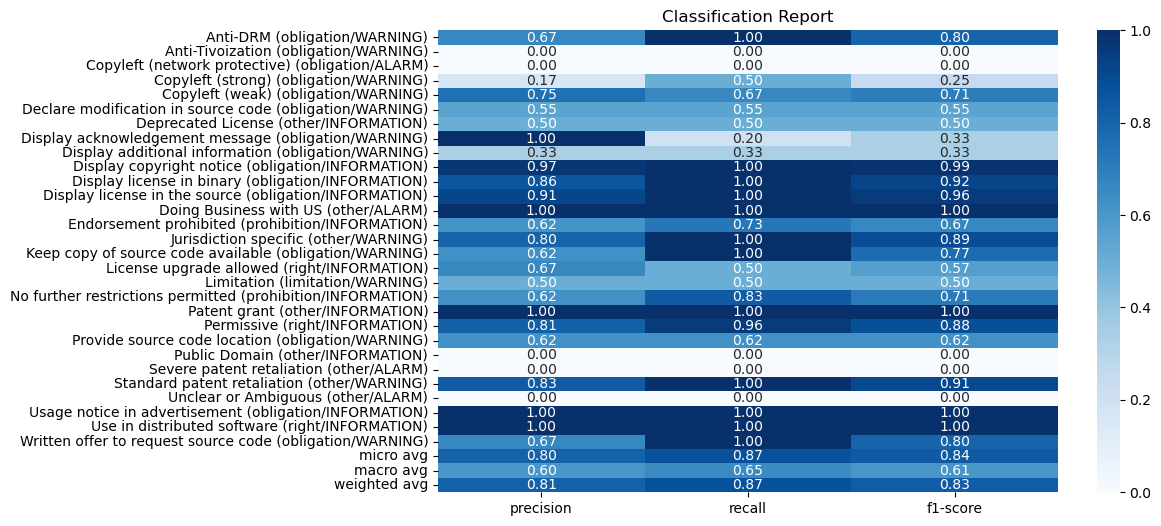

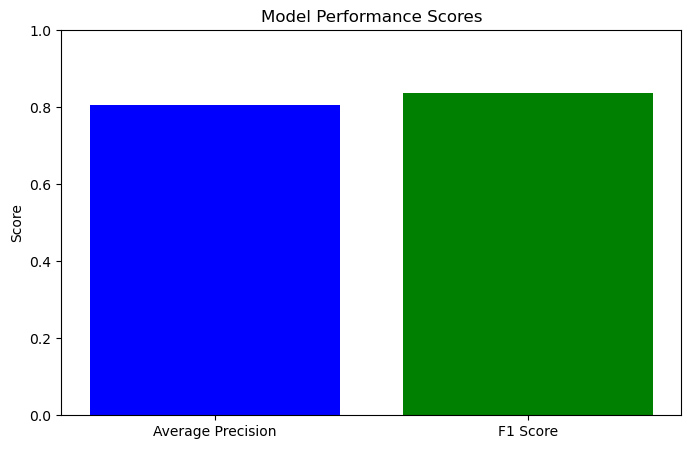

In [48]:
def analyze_errors(model, dataloader, device, label_names, best_thresholds):
    """Analyzes the errors made by the model on the given dataloader.

    Args:
        model: The trained model.
        dataloader: The dataloader containing the evaluation data.
        device: The device (CPU or GPU).
        label_names: A list of label names.
        best_thresholds: A list of the best thresholds for each label.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_texts = []  # Store the texts for analysis

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Get the text corresponding to the input IDs
            texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            all_texts.extend(texts)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)

            # Apply the best thresholds to get predictions
            predictions = (probs > torch.tensor(best_thresholds).to(device)).int()

            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # (1) Classification Report (per label)
    print(classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0))

    # (2) Confusion Matrix (per label)
    for i, label_name in enumerate(label_names):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        print(f"\nConfusion Matrix for label: {label_name}")
        print(cm)

    # (3) Examine Misclassified Examples
    print("\nMisclassified Examples:")
    for i in range(len(all_texts)):
        if (all_predictions[i] != all_labels[i]).any():  # If any label is misclassified
            print(f"\nText: {all_texts[i]}")
            print(f"True Labels: {[label_names[j] for j in range(len(label_names)) if all_labels[i][j] == 1]}")
            print(f"Predicted Labels: {[label_names[j] for j in range(len(label_names)) if all_predictions[i][j] == 1]}")
            # You can add more detailed analysis here, such as:
            # - Which labels were incorrectly predicted?
            # - What were the predicted probabilities for those labels?
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    plot_classification_report(y_true, y_pred, mlb.classes_)
    plot_model_scores(y_true, y_pred, mlb.classes_)
    

# Example Usage:
analyze_errors(model, val_dataloader, device, mlb.classes_, best_thresholds)  # Assumes you have mlb (MultiLabelBinarizer) from before